   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


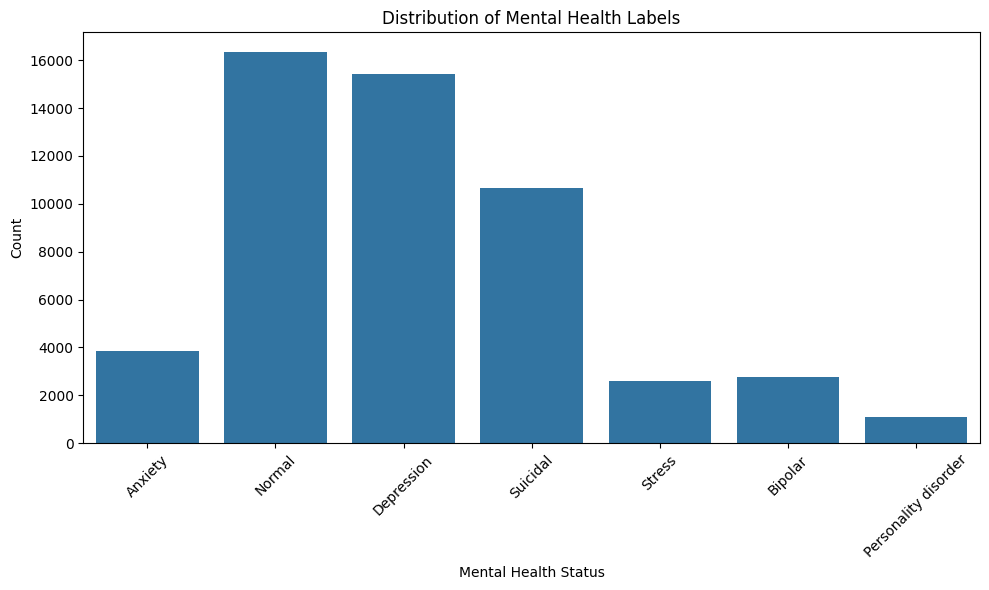

In [4]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
dataset = load_dataset("btwitssayan/sentiment-analysis-for-mental-health")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Display the first few rows
print(df.head())

# Visualize the distribution of labels
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='status')
plt.title('Distribution of Mental Health Labels')
plt.xlabel('Mental Health Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
!pip install nltk tqdm --quiet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  # for lemmatization (optional)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
import nltk

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    # Lowercase
    tweet = tweet.lower()
    # Remove URLs, mentions, hashtags
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuation and numbers
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    # Tokenize
    tokens = word_tokenize(tweet)
    # Remove stopwords and lemmatize
    filtered = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(filtered)

# Apply to the dataset with progress bar
tqdm.pandas()
df['clean_text'] = df['statement'].progress_apply(clean_tweet)

# Preview cleaned data
df[['statement', 'clean_text']].head()

100%|██████████| 52681/52681 [00:41<00:00, 1267.05it/s]


,statement,clean_text
0,oh my gosh,oh gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,ive shifted focus something else im still worried
4,"I'm restless and restless, it's been a month n...",im restless restless month boy mean


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit to top 5000 words

# Fit and transform the clean text
X = tfidf.fit_transform(df['clean_text']).toarray()

# Store the target variable (e.g., Anxiety, Depression, etc.)
y = df['status']

In [12]:
print("TF-IDF shape:", X.shape)
print("Labels:", y.unique())

TF-IDF shape: (52681, 5000)
Labels: ['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# For reference: which label maps to which number
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label encoding:", label_map)

Label encoding: {'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.83      0.75      0.78       768
             Bipolar       0.84      0.69      0.76       556
          Depression       0.70      0.74      0.72      3081
              Normal       0.83      0.95      0.89      3269
Personality disorder       0.83      0.53      0.65       215
              Stress       0.66      0.41      0.51       517
            Suicidal       0.68      0.62      0.65      2131

            accuracy                           0.76     10537
           macro avg       0.77      0.67      0.71     10537
        weighted avg       0.75      0.76      0.75     10537



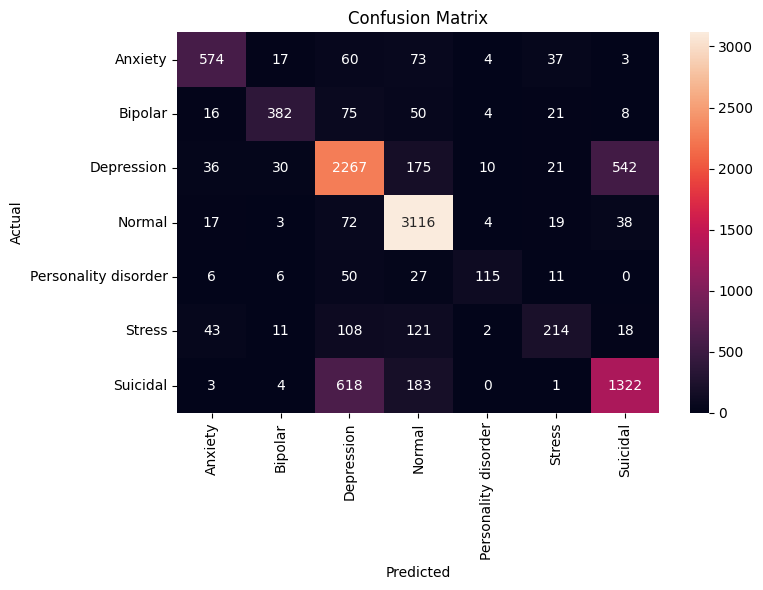

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 2: Fit a Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Step 3: Predict on the test set
y_pred = clf.predict(X_test)

# Step 4: Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

# Function to train and evaluate each model
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🔍 {model_name} Performance")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f} | Weighted F1-score: {f1:.4f}")
    return model_name, acc, f1

# Models
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Evaluate all
results = []
for name, model in models.items():
    results.append(evaluate_model(model, name))



🔍 Multinomial Naive Bayes Performance
                      precision    recall  f1-score   support

             Anxiety       0.79      0.61      0.69       768
             Bipolar       0.87      0.49      0.63       556
          Depression       0.52      0.80      0.63      3081
              Normal       0.83      0.83      0.83      3269
Personality disorder       1.00      0.12      0.21       215
              Stress       0.78      0.09      0.16       517
            Suicidal       0.69      0.49      0.57      2131

            accuracy                           0.67     10537
           macro avg       0.78      0.49      0.53     10537
        weighted avg       0.71      0.67      0.65     10537

Accuracy: 0.6681 | Weighted F1-score: 0.6530

🔍 Support Vector Machine Performance
                      precision    recall  f1-score   support

             Anxiety       0.80      0.77      0.78       768
             Bipolar       0.81      0.76      0.78       556
      

In [17]:
from sklearn.linear_model import LogisticRegression

# Re-initialize logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Train and evaluate using the same function
results = []

# Logistic Regression
results.append(evaluate_model(logreg, "Logistic Regression"))

# Multinomial Naive Bayes
results.append(evaluate_model(MultinomialNB(), "Multinomial Naive Bayes"))

# Support Vector Machine
results.append(evaluate_model(LinearSVC(), "Support Vector Machine"))

# Random Forest
results.append(evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"))


🔍 Logistic Regression Performance
                      precision    recall  f1-score   support

             Anxiety       0.83      0.75      0.78       768
             Bipolar       0.84      0.69      0.76       556
          Depression       0.70      0.74      0.72      3081
              Normal       0.83      0.95      0.89      3269
Personality disorder       0.83      0.53      0.65       215
              Stress       0.66      0.41      0.51       517
            Suicidal       0.68      0.62      0.65      2131

            accuracy                           0.76     10537
           macro avg       0.77      0.67      0.71     10537
        weighted avg       0.75      0.76      0.75     10537

Accuracy: 0.7583 | Weighted F1-score: 0.7521

🔍 Multinomial Naive Bayes Performance
                      precision    recall  f1-score   support

             Anxiety       0.79      0.61      0.69       768
             Bipolar       0.87      0.49      0.63       556
         

In [18]:
# Find and print the best model
best_model = max(results, key=lambda x: x[2])  # Sort by weighted F1-score
print(f"\n🏆 Best model: {best_model[0]} with F1-score of {best_model[2]:.4f}")


🏆 Best model: Logistic Regression with F1-score of 0.7521


In [19]:
!pip install tensorflow --quiet

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences
X_seq = pad_sequences(sequences, padding='post', maxlen=100)

# Encode labels (again, for safety)
from sklearn.preprocessing import LabelEncoder
le_dl = LabelEncoder()
y_dl = le_dl.fit_transform(df['status'])

# One-hot encode for Keras
from tensorflow.keras.utils import to_categorical
y_dl_cat = to_categorical(y_dl)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_dl_cat.shape[1], activation='softmax')
])

# Build the model manually using input shape
model.build(input_shape=(None, X_seq.shape[1]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,639 (2.58 MB)

 Trainable params: 677,639 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from sklearn.model_selection import train_test_split

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_seq, y_dl_cat, test_size=0.2, random_state=42, stratify=y_dl)

# Train
history = model.fit(
    X_train_dl, y_train_dl,
    epochs=5,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 189ms/step - accuracy: 0.3240 - loss: 1.6651 - val_accuracy: 0.4335 - val_loss: 1.4546
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 81s 188ms/step - accuracy: 0.3785 - loss: 1.4837 - val_accuracy: 0.4168 - val_loss: 1.3868
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 54s 183ms/step - accuracy: 0.4029 - loss: 1.4077 - val_accuracy: 0.3763 - val_loss: 1.5171
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - accuracy: 0.4099 - loss: 1.4942 - val_accuracy: 0.5096 - val_loss: 1.2423
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.5287 - loss: 1.2019 - val_accuracy: 0.5839 - val_loss: 0.9651


In [26]:
# Evaluate
loss, acc = model.evaluate(X_test_dl, y_test_dl)
print(f"✅ LSTM Accuracy: {acc:.4f}")

# Predict
y_pred_dl = model.predict(X_test_dl)
y_pred_labels = y_pred_dl.argmax(axis=1)
y_true_labels = y_test_dl.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels, target_names=le_dl.classes_))

330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5861 - loss: 0.9757
✅ LSTM Accuracy: 0.5849
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
                      precision    recall  f1-score   support

             Anxiety       0.30      0.51      0.38       768
             Bipolar       0.28      0.25      0.27       556
          Depression       0.52      0.86      0.65      3081
              Normal       0.81      0.91      0.86      3269
Personality disorder       0.00      0.00      0.00       215
              Stress       0.00      0.00      0.00       517
            Suicidal       0.00      0.00      0.00      2131

            accuracy                           0.58     10537
           macro avg       0.27      0.36      0.31     10537
        weighted avg       0.44      0.58      0.50     10537



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
!pip install transformers[tf] datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 815.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/44

In [39]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load PyTorch model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le_dl.classes_))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from datasets import Dataset

# Convert to Hugging Face Dataset format
train_dict = {'text': X_train, 'label': y_train}
test_dict = {'text': X_test, 'label': y_test}

train_ds = Dataset.from_dict(train_dict)
test_ds = Dataset.from_dict(test_dict)

# Tokenize
def tokenize_fn(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)

# Set format for PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/42144 [00:00<?, ? examples/s]

Map:   0%|          | 0/10537 [00:00<?, ? examples/s]

In [42]:
!pip install -U transformers --quiet

In [43]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer
)

trainer.train()

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [38]:
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=le_dl.classes_))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7eb284627f90>